In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import layers, models, optimizers
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from scipy.interpolate import interp1d

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def nanscaler(seri):
    temp_list = []
    series_mean = seri.mean()
    series_std = seri.std()
    for i in seri:
        if np.isnan(i):
            temp_list.append(0)
        else :
            temp_list.append((i - series_mean)/series_std)
    return series_mean, series_std, temp_list 

def nanscaler_test(s_mean,s_std,seri):
    temp_list = []
    for i in seri:
        if np.isnan(i):
            temp_list.append(0)
        else :
            temp_list.append((i - s_mean)/s_std)
    return temp_list

In [3]:
df = pd.read_csv('trainMerged.csv')
test_df = pd.read_csv('testMerged.csv')
df['Date'] = pd.to_datetime(df.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)
df['IsHoliday'] = df.IsHoliday.astype('int')
test_df['IsHoliday'] = test_df.IsHoliday.astype('int')
MarkDowns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i in MarkDowns:
    s_mean,s_std, df[i] = nanscaler(df[i])
    test_df[i] = nanscaler_test(s_mean,s_std,test_df[i])

In [4]:
df['Day_of_year'] = [i.dayofyear for i in df.Date]
test_df['Day_of_year'] = [i.dayofyear for i in test_df.Date]
df['Year'] = [i.year for i in df.Date]

In [5]:
doy = []
for i,d in enumerate(df.Day_of_year):
    j = d
    if df['Year'][i] == 2012:
        if d > 60:
            j -= 1
    doy.append(j)
df['Day_of_year'] = doy
df.drop(['Year'],axis=1,inplace=True)
tempp = test_df.Date - pd.to_datetime('2010-01-01')
test_df['total_days'] = [i.total_seconds()/86400 for i in tempp]
tempp = df.Date - pd.to_datetime('2010-01-01')
df['total_days'] = [i.total_seconds()/86400 for i in tempp]
test_df['CPI'] = test_df.groupby('Store')['CPI'].transform(lambda x : x.fillna(x.mean()))
test_df['Unemployment'] = test_df.groupby('Store')['Unemployment'].transform(lambda x : x.fillna(x.mean()))

In [6]:
zero_1_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))


In [7]:
#['Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Type', 'Size',
#'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
#'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Day_of_year']
num_cols = ['Size', 'Temperature', 'Fuel_Price','CPI' ,'Unemployment','Day_of_year']
num_df = df[num_cols]
num_df_test = test_df[num_cols]
cat_df = pd.get_dummies(df[['Store','Type']].astype('str'))
cat_df_test = pd.get_dummies(test_df[['Store','Type']].astype('str'))
zero_1_scaler.fit(num_df)
num_df = pd.DataFrame(zero_1_scaler.transform(num_df),columns=num_df.columns)
num_df_test = pd.DataFrame(zero_1_scaler.transform(num_df_test),columns=num_df_test.columns)

In [8]:
df_1 = pd.concat([num_df,cat_df,df['Dept'],df['Weekly_Sales']],axis= 1)
test_1 = pd.concat([num_df_test,cat_df_test,test_df['Dept']], axis=1)
test_1['Day_of_year'][test_1.Day_of_year< 0] = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# aa1 = df_1.values
# np.random.shuffle(aa1)
# tr_1 = aa1[:400000,:-1]
# lbl_1 = aa1[:400000,-1]
# val_1 = aa1[400000:,:-1]
# val_lbl_1 = aa1[400000:,-1]
aa = df_1.groupby('Dept')
bb = test_1.groupby('Dept')
departments = df.Dept.unique()
X_train = dict()
X_test = dict()
X_val = dict()
y_train = dict()
y_val = dict()
# for dep in departments:
#     gr_df = aa.get_group(dep).values
#     np.random.shuffle(inds)
    

In [10]:
aa.get_group(1).shape

(6435, 56)

In [11]:
ffd = aa.get_group(1).values
np.random.shuffle(ffd)
X_tr = ffd[:,:-2]
y_tr = ffd[:,-1]
X_v = ffd[-700:,:-2]
y_v = ffd[-700:,-1]

In [28]:
dep1 = aa.get_group(1)
df.Size.describe()

count    421570.000000
mean     136727.915739
std       60980.583328
min       34875.000000
25%       93638.000000
50%      140167.000000
75%      202505.000000
max      219622.000000
Name: Size, dtype: float64

In [52]:
from sklearn.model_selection import GridSearchCV
regressor = SVR()
params = {'C':[1,100,.01],'gamma':[.001,.01,1]}
gs = GridSearchCV(regressor,param_grid = params, scoring = 'neg_mean_squared_error')

In [53]:
gs.fit(X_tr,y_tr)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 100, 0.01], 'gamma': [0.001, 0.01, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [56]:
X_tr.shape

(6435, 54)

In [54]:
mean_absolute_error(y_v, gs.best_estimator_.predict(X_v))

5379.795305754263

In [22]:
pd.Series(y_tr).describe()

count      6435.000000
mean      19213.485088
std       15102.373853
min         711.110000
25%       10423.465000
50%       15314.910000
75%       23135.595000
max      172225.550000
dtype: float64

In [12]:

regressor.fit(X_tr,y_tr)
mean_absolute_error(y_v, regressor.predict(X_v))

8864.322347526593

In [ ]:
regressor.

In [12]:
model1 = models.Sequential()
model1.add(layers.Dense(128,activation='relu',input_shape = (54,)))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(128,activation= 'relu'))
model1.add(layers.Dense(128,activation= 'relu'))
model1.add(layers.Dense(1))
model1.compile(loss='mse', optimizer='Adam', metrics=['mae'])

In [13]:
# model1.summary()
model1.fit(X_tr,y_tr,epochs= 500, validation_split=0.1)

Train on 5791 samples, validate on 644 samples
Epoch 1/500
5791/5791 [==============================] - 16s 3ms/step - loss: 350263711.0275 - mean_absolute_error: 12944.1424 - val_loss: 167752535.0062 - val_mean_absolute_error: 8117.1595
Epoch 2/500
5791/5791 [==============================] - 1s 180us/step - loss: 151795977.8898 - mean_absolute_error: 7238.4550 - val_loss: 128455118.8323 - val_mean_absolute_error: 7162.8186
Epoch 3/500
5791/5791 [==============================] - 1s 174us/step - loss: 128251182.5025 - mean_absolute_error: 6283.8138 - val_loss: 114914476.9193 - val_mean_absolute_error: 6218.3355
Epoch 4/500
5791/5791 [==============================] - 1s 178us/step - loss: 120488116.2079 - mean_absolute_error: 5927.3379 - val_loss: 109346275.6646 - val_mean_absolute_error: 5909.8488
Epoch 5/500
5791/5791 [==============================] - 1s 181us/step - loss: 117227977.0727 - mean_absolute_error: 5806.9008 - val_loss: 105319091.3168 - val_mean_absolute_error: 5648.403

Epoch 44/500
5791/5791 [==============================] - 1s 216us/step - loss: 108881737.5845 - mean_absolute_error: 5320.1602 - val_loss: 94514487.7267 - val_mean_absolute_error: 5133.5350
Epoch 45/500
5791/5791 [==============================] - 2s 303us/step - loss: 108144356.1527 - mean_absolute_error: 5316.8765 - val_loss: 95912285.3758 - val_mean_absolute_error: 5013.0408
Epoch 46/500
5791/5791 [==============================] - 1s 240us/step - loss: 107809627.5572 - mean_absolute_error: 5310.7275 - val_loss: 97751186.4286 - val_mean_absolute_error: 5831.9924
Epoch 47/500
5791/5791 [==============================] - 1s 214us/step - loss: 108325919.4502 - mean_absolute_error: 5273.8365 - val_loss: 95635147.5839 - val_mean_absolute_error: 4990.7141
Epoch 48/500
5791/5791 [==============================] - 1s 223us/step - loss: 108624147.2685 - mean_absolute_error: 5340.1023 - val_loss: 97234412.2857 - val_mean_absolute_error: 5911.4597
Epoch 49/500
5791/5791 [=====================

Epoch 87/500
5791/5791 [==============================] - 1s 193us/step - loss: 99649553.5424 - mean_absolute_error: 5183.5377 - val_loss: 92452832.0839 - val_mean_absolute_error: 4990.4188
Epoch 88/500
5791/5791 [==============================] - 1s 195us/step - loss: 98146727.6387 - mean_absolute_error: 5206.2086 - val_loss: 92761469.4752 - val_mean_absolute_error: 4979.9348
Epoch 89/500
5791/5791 [==============================] - ETA: 0s - loss: 100187373.6264 - mean_absolute_error: 5230.82 - 1s 190us/step - loss: 99210098.3644 - mean_absolute_error: 5205.9618 - val_loss: 92638798.1801 - val_mean_absolute_error: 5107.6308
Epoch 90/500
5791/5791 [==============================] - 1s 195us/step - loss: 97773501.2219 - mean_absolute_error: 5215.9516 - val_loss: 94932056.9472 - val_mean_absolute_error: 5058.6563
Epoch 91/500
5791/5791 [==============================] - 1s 195us/step - loss: 98274844.1913 - mean_absolute_error: 5185.8139 - val_loss: 91690767.2267 - val_mean_absolute_err

5791/5791 [==============================] - 1s 192us/step - loss: 91609923.4474 - mean_absolute_error: 4919.7212 - val_loss: 87378212.9488 - val_mean_absolute_error: 4931.7464
Epoch 130/500
5791/5791 [==============================] - 1s 192us/step - loss: 91890222.0176 - mean_absolute_error: 4950.5931 - val_loss: 89307594.2484 - val_mean_absolute_error: 5098.4364
Epoch 131/500
5791/5791 [==============================] - 1s 193us/step - loss: 90916274.6496 - mean_absolute_error: 4891.0906 - val_loss: 88524174.1289 - val_mean_absolute_error: 4860.8717
Epoch 132/500
5791/5791 [==============================] - 1s 199us/step - loss: 91136314.9549 - mean_absolute_error: 4909.8420 - val_loss: 87425703.9969 - val_mean_absolute_error: 5122.5809
Epoch 133/500
5791/5791 [==============================] - 1s 186us/step - loss: 90693082.1703 - mean_absolute_error: 4922.5942 - val_loss: 88973367.0000 - val_mean_absolute_error: 5091.1249
Epoch 134/500
5791/5791 [==============================] - 

Epoch 172/500
5791/5791 [==============================] - 1s 214us/step - loss: 85489566.1675 - mean_absolute_error: 4773.0508 - val_loss: 86446933.4255 - val_mean_absolute_error: 4886.0873
Epoch 173/500
5791/5791 [==============================] - 1s 223us/step - loss: 84095493.2053 - mean_absolute_error: 4701.1672 - val_loss: 85586592.9161 - val_mean_absolute_error: 4977.1988
Epoch 174/500
5791/5791 [==============================] - 1s 255us/step - loss: 85961879.8107 - mean_absolute_error: 4788.6828 - val_loss: 83951572.9255 - val_mean_absolute_error: 5012.9197
Epoch 175/500
5791/5791 [==============================] - 1s 207us/step - loss: 84305262.3796 - mean_absolute_error: 4715.5482 - val_loss: 86330839.6957 - val_mean_absolute_error: 4779.1618
Epoch 176/500
5791/5791 [==============================] - 1s 202us/step - loss: 84683953.0195 - mean_absolute_error: 4706.8166 - val_loss: 84765294.9689 - val_mean_absolute_error: 4842.4963
Epoch 177/500
5791/5791 [====================

Epoch 215/500
5791/5791 [==============================] - 1s 197us/step - loss: 77913130.7367 - mean_absolute_error: 4455.3545 - val_loss: 86319243.9503 - val_mean_absolute_error: 4591.5907
Epoch 216/500
5791/5791 [==============================] - 1s 190us/step - loss: 75743690.5971 - mean_absolute_error: 4424.2257 - val_loss: 84433987.5901 - val_mean_absolute_error: 5190.9947
Epoch 217/500
5791/5791 [==============================] - 1s 195us/step - loss: 76647399.5386 - mean_absolute_error: 4513.3931 - val_loss: 82841289.4845 - val_mean_absolute_error: 4579.8262
Epoch 218/500
5791/5791 [==============================] - 1s 194us/step - loss: 76562970.5405 - mean_absolute_error: 4439.1332 - val_loss: 82746930.2003 - val_mean_absolute_error: 4607.4945
Epoch 219/500
5791/5791 [==============================] - 1s 197us/step - loss: 77003317.1680 - mean_absolute_error: 4451.4245 - val_loss: 86272601.1848 - val_mean_absolute_error: 4623.8096
Epoch 220/500
5791/5791 [====================

Epoch 258/500
5791/5791 [==============================] - 1s 213us/step - loss: 69711574.1295 - mean_absolute_error: 4227.9563 - val_loss: 83236432.7252 - val_mean_absolute_error: 4700.1685
Epoch 259/500
5791/5791 [==============================] - 1s 227us/step - loss: 68266048.8316 - mean_absolute_error: 4215.8337 - val_loss: 85337260.0373 - val_mean_absolute_error: 4961.0247
Epoch 260/500
5791/5791 [==============================] - 1s 254us/step - loss: 68524202.9439 - mean_absolute_error: 4243.1849 - val_loss: 84567805.0839 - val_mean_absolute_error: 4549.1158
Epoch 261/500
5791/5791 [==============================] - 1s 256us/step - loss: 68937261.7510 - mean_absolute_error: 4240.9982 - val_loss: 87113905.1708 - val_mean_absolute_error: 4729.6808
Epoch 262/500
5791/5791 [==============================] - 2s 284us/step - loss: 68880914.4576 - mean_absolute_error: 4231.5584 - val_loss: 83783186.6972 - val_mean_absolute_error: 4972.6783
Epoch 263/500
5791/5791 [====================

Epoch 301/500
5791/5791 [==============================] - 1s 193us/step - loss: 61854266.9449 - mean_absolute_error: 4076.4158 - val_loss: 83991352.3106 - val_mean_absolute_error: 4765.7536
Epoch 302/500
5791/5791 [==============================] - 1s 192us/step - loss: 61116318.4155 - mean_absolute_error: 3959.5528 - val_loss: 84398841.2446 - val_mean_absolute_error: 4693.1561
Epoch 303/500
5791/5791 [==============================] - 1s 192us/step - loss: 62707045.5742 - mean_absolute_error: 4081.0415 - val_loss: 83425629.9130 - val_mean_absolute_error: 4790.5144
Epoch 304/500
5791/5791 [==============================] - 1s 200us/step - loss: 61501443.7251 - mean_absolute_error: 4033.8281 - val_loss: 80480997.8152 - val_mean_absolute_error: 4552.8576
Epoch 305/500
5791/5791 [==============================] - 1s 195us/step - loss: 60176076.5218 - mean_absolute_error: 3960.4127 - val_loss: 83991649.9290 - val_mean_absolute_error: 4660.2188
Epoch 306/500
5791/5791 [====================

Epoch 344/500
5791/5791 [==============================] - 1s 192us/step - loss: 54833974.7512 - mean_absolute_error: 3821.0360 - val_loss: 85382880.0870 - val_mean_absolute_error: 5045.3819
Epoch 345/500
5791/5791 [==============================] - 1s 193us/step - loss: 54780652.2645 - mean_absolute_error: 3914.3041 - val_loss: 89607080.1429 - val_mean_absolute_error: 4981.9892
Epoch 346/500
5791/5791 [==============================] - 1s 195us/step - loss: 54095434.5108 - mean_absolute_error: 3796.5512 - val_loss: 84936123.2151 - val_mean_absolute_error: 4801.8406
Epoch 347/500
5791/5791 [==============================] - 1s 198us/step - loss: 53149196.9518 - mean_absolute_error: 3756.0068 - val_loss: 87559147.0543 - val_mean_absolute_error: 4698.3869
Epoch 348/500
5791/5791 [==============================] - 1s 195us/step - loss: 53457798.8796 - mean_absolute_error: 3743.3233 - val_loss: 88206237.5652 - val_mean_absolute_error: 4736.6498
Epoch 349/500
5791/5791 [====================

Epoch 387/500
5791/5791 [==============================] - 1s 196us/step - loss: 47301273.6135 - mean_absolute_error: 3566.0484 - val_loss: 84773150.6957 - val_mean_absolute_error: 4746.9381
Epoch 388/500
5791/5791 [==============================] - 1s 191us/step - loss: 50172742.7898 - mean_absolute_error: 3644.4075 - val_loss: 101487154.6087 - val_mean_absolute_error: 5094.9898
Epoch 389/500
5791/5791 [==============================] - 1s 195us/step - loss: 44850037.0920 - mean_absolute_error: 3509.1185 - val_loss: 89958982.0870 - val_mean_absolute_error: 4638.4156
Epoch 390/500
5791/5791 [==============================] - 1s 192us/step - loss: 45378557.2430 - mean_absolute_error: 3471.3278 - val_loss: 87693659.9130 - val_mean_absolute_error: 4810.2662
Epoch 391/500
5791/5791 [==============================] - 1s 195us/step - loss: 46252140.0421 - mean_absolute_error: 3537.9436 - val_loss: 90007582.5000 - val_mean_absolute_error: 4626.7727
Epoch 392/500
5791/5791 [===================

Epoch 430/500
5791/5791 [==============================] - 1s 193us/step - loss: 42203472.5277 - mean_absolute_error: 3298.5530 - val_loss: 94025047.5699 - val_mean_absolute_error: 4771.1362
Epoch 431/500
5791/5791 [==============================] - 1s 193us/step - loss: 43021297.8712 - mean_absolute_error: 3388.3782 - val_loss: 92285857.2019 - val_mean_absolute_error: 4571.7293
Epoch 432/500
5791/5791 [==============================] - 1s 193us/step - loss: 39604886.9822 - mean_absolute_error: 3242.6145 - val_loss: 97314213.6491 - val_mean_absolute_error: 4643.9656
Epoch 433/500
5791/5791 [==============================] - 1s 193us/step - loss: 40673101.3856 - mean_absolute_error: 3218.8752 - val_loss: 91773039.6266 - val_mean_absolute_error: 4607.4951
Epoch 434/500
5791/5791 [==============================] - 1s 192us/step - loss: 41157384.5999 - mean_absolute_error: 3268.3864 - val_loss: 90817228.2935 - val_mean_absolute_error: 4594.8916
Epoch 435/500
5791/5791 [====================

Epoch 473/500
5791/5791 [==============================] - 1s 249us/step - loss: 36484150.5702 - mean_absolute_error: 3099.6764 - val_loss: 88601833.7205 - val_mean_absolute_error: 4683.8580
Epoch 474/500
5791/5791 [==============================] - 2s 265us/step - loss: 36276618.8765 - mean_absolute_error: 3070.6984 - val_loss: 98904972.6988 - val_mean_absolute_error: 4714.8988
Epoch 475/500
5791/5791 [==============================] - 1s 237us/step - loss: 36832734.0894 - mean_absolute_error: 3070.1406 - val_loss: 91907376.1615 - val_mean_absolute_error: 4499.4280
Epoch 476/500
5791/5791 [==============================] - 1s 226us/step - loss: 36682443.6501 - mean_absolute_error: 3054.3429 - val_loss: 90554453.0419 - val_mean_absolute_error: 4626.4163
Epoch 477/500
5791/5791 [==============================] - 1s 204us/step - loss: 43813037.7831 - mean_absolute_error: 3242.0560 - val_loss: 93945226.3882 - val_mean_absolute_error: 4779.4432
Epoch 478/500
5791/5791 [====================

In [86]:
aa = df_1.groupby('Dept')

In [89]:
grp_dep_doy = dict()
for i, j in aa:
    grp_dep_doy[i] = j.groupby('Day_of_year')['Weekly_Sales'].mean()
grp_dep_doy = pd.DataFrame(grp_dep_doy)
grp_dep_doy.sort_index(inplace=True)
grp_dep_doy.fillna(0 ,inplace= True)

In [58]:
def get_sales_mean(doy, dep):
    f = interp1d(grp_dep_doy.index, grp_dep_doy[dep])
    return f(doy)

In [90]:
tes_mean_sales = []
for dep, doy in zip(test_1.Dept, test_1.Day_of_year):
    tes_mean_sales.append(get_sales_mean(doy,dep))

In [91]:
test_1['Mean_Sales'] = tes_mean_sales
test_1['Mean_Sales'].isnull().sum()

0

In [95]:
tr_mean_sales = []
for dep, doy in zip(df_1.Dept, df_1.Day_of_year):
    tr_mean_sales.append(grp_dep_doy[dep][doy])
df_1['Mean_Sales'] = tr_mean_sales

In [96]:
df_1 = df_1[['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Day_of_year', 'Store_1', 'Store_10', 'Store_11', 'Store_12',
       'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18',
       'Store_19', 'Store_2', 'Store_20', 'Store_21', 'Store_22', 'Store_23',
       'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29',
       'Store_3', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
       'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_4',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Type_A',
       'Type_B', 'Type_C','Mean_Sales', 'Dept', 'Weekly_Sales'
       ]]
test_1 = test_1[['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Day_of_year', 'Store_1', 'Store_10', 'Store_11', 'Store_12',
       'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18',
       'Store_19', 'Store_2', 'Store_20', 'Store_21', 'Store_22', 'Store_23',
       'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29',
       'Store_3', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
       'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_4',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Type_A',
       'Type_B', 'Type_C','Mean_Sales', 'Dept',
       ]]

Index(['Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Day_of_year', 'Store_1', 'Store_10', 'Store_11', 'Store_12',
       'Store_13', 'Store_14', 'Store_15', 'Store_16', 'Store_17', 'Store_18',
       'Store_19', 'Store_2', 'Store_20', 'Store_21', 'Store_22', 'Store_23',
       'Store_24', 'Store_25', 'Store_26', 'Store_27', 'Store_28', 'Store_29',
       'Store_3', 'Store_30', 'Store_31', 'Store_32', 'Store_33', 'Store_34',
       'Store_35', 'Store_36', 'Store_37', 'Store_38', 'Store_39', 'Store_4',
       'Store_40', 'Store_41', 'Store_42', 'Store_43', 'Store_44', 'Store_45',
       'Store_5', 'Store_6', 'Store_7', 'Store_8', 'Store_9', 'Type_A',
       'Type_B', 'Type_C', 'Dept', 'Weekly_Sales', 'Scaled_Week_Sales',
       'Mean_Sales'],
      dtype='object')

In [ ]:
stores = df.Store.unique()
dept_no = 7
for store_no in stores:
    bb = aa.get_group(store_no)
    bb = bb[bb.Dept==dept_no]
    bb.index = range(len(bb))
    bb = np.split(bb, bb[bb.round_days.diff()<0].index, axis = 0)
    for i in bb:
        plt.plot(i.round_days,i.Weekly_Sales/(i.Weekly_Sales.mean()))

In [40]:
aa.colum

AttributeError: Cannot access attribute 'index' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [29]:
mean_sale

Day_of_year
0.000000    13180.086889
0.002786    11628.317333
0.019499    13624.038000
0.022284    12730.946000
0.038997    14669.180444
0.041783    13864.207111
0.058496    15126.391778
0.061281    14499.738000
0.077994    18216.596444
0.080780    17613.400667
0.083565    19596.298000
0.097493    25121.113333
0.100279    26941.714444
0.103064    32381.831111
0.116992    39540.355778
0.119777    32470.996444
0.122563    24850.163556
0.136490    15634.010667
0.139276    13765.470444
0.142061    15142.035111
0.153203    17540.764222
0.158774    15201.214222
0.161560    16947.834889
0.172702    17567.973111
0.178273    15638.433111
0.181058    17864.154000
0.192201    18882.558222
0.197772    16074.316444
0.200557    18815.254889
0.211699    20093.242000
                ...     
0.757660    19008.062889
0.763231    19210.683778
0.766017    19767.443111
0.777159    20815.728444
0.782730    20563.906889
0.785515    21815.235333
0.796657    23048.499111
0.802228    23839.922222
0.805014    2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


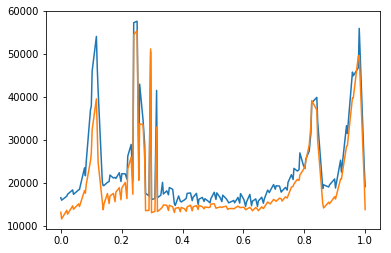